# Engagement Dataset Analysis
Full EDA, preprocessing, ML models with MLflow placeholders.

In [35]:
import os
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib
import mlflow

# visual settings (dark mode)
DARK_PALETTE = [
    "#9D00FF",  
    "#00FFFF",  
    "#FF007F",  
    "#FFD300",  
    "#39FF14",  
    "#FF5F1F",  
    "#00BFFF", 
]

plt.style.use('dark_background')
sns.set_palette(DARK_PALETTE)

warnings.filterwarnings("ignore")

# paths and mlflow
DATA_PATH = "metrics_log.csv"
PROCESSED_DIR = "processed"
ARTIFACTS_DIR = "artifacts"
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

MLFLOW_EXPERIMENT_NAME = "gaze_engagement_classification"
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print("Ready — MLflow experiment:", MLFLOW_EXPERIMENT_NAME)

Ready — MLflow experiment: gaze_engagement_classification


## Utils & MLFlow

In [36]:
def save_matplotlib_fig(fig, name):
    path = os.path.join(ARTIFACTS_DIR, f"{name}.png")
    fig.savefig(path, dpi=250, bbox_inches="tight")
    return path

def log_matplotlib_fig(fig, name):
    path = save_matplotlib_fig(fig, name)
    mlflow.log_artifact(path)

def save_plotly_fig(fig, name):
    png_path = os.path.join(ARTIFACTS_DIR, f"{name}.png")
    html_path = os.path.join(ARTIFACTS_DIR, f"{name}.html")
    try:
        fig.write_image(png_path, scale=2)   # requires kaleido
        mlflow.log_artifact(png_path)
        return png_path
    except Exception:
        fig.write_html(html_path)
        mlflow.log_artifact(html_path)
        return html_path

def save_and_log_df(df, name):
    p = os.path.join(PROCESSED_DIR, name)
    df.to_csv(p, index=False)
    mlflow.log_artifact(p)
    return p

def log_confusion_matrix(y_true, y_pred, labels, name):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(name)
    plt.tight_layout()
    log_matplotlib_fig(fig, name.replace(" ", "_"))
    plt.close(fig)


## Load Data 

### We Collect data from 2 Main sources : 
- Daisee Dataset 
- Metrics_Log output from inference , collected by our team .
- This analysis is on Metrics_Log 
- The Viausl

In [37]:
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
display(df.head())

# log dataset-level info
with mlflow.start_run(run_name="data_overview", nested=True):
    mlflow.log_param("dataset_path", DATA_PATH)
    mlflow.log_param("rows", df.shape[0])
    mlflow.log_param("cols", df.shape[1])
    mlflow.log_dict(df.isnull().sum().to_dict(), "missing_values.json")

Loaded: metrics_log.csv shape: (2538, 16)


,timestamp_ms,frame,face_det_ms,gaze_est_ms,blink_det_ms,num_faces,pitch_deg,yaw_deg,ear,blink_rate_10s_bps,blink_state,engagement_score,engagement_level,engagement_trend,is_blinking,is_calibrated
0,1762453779535,1,85.145473,212.038279,2.007484,1,-12.070953,0.103302,29.256381,0.0,normal,30.500000,3.0,stable,False,False
1,1762453779939,2,118.303299,15.745401,10.304928,1,-8.408386,2.995728,27.632181,0.0,normal,38.750000,3.0,stable,False,False
2,1762453780116,3,107.240438,9.071827,7.002354,1,-6.729568,9.062881,27.273493,0.0,normal,47.446573,3.0,stable,False,False
3,1762453780287,4,104.197502,19.976139,4.050016,1,-14.350800,-2.902222,22.930228,0.0,normal,50.612601,3.0,stable,False,False
4,1762453780451,5,91.351986,12.053013,4.005432,1,-5.140762,7.116791,26.738711,0.0,normal,54.539433,3.0,stable,False,False


In [38]:
print(df.info())

if 'timestamp_ms' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp_ms'], unit='ms', errors='coerce')

numeric_cols = [
    'face_det_ms','gaze_est_ms','blink_det_ms','num_faces',
    'pitch_deg','yaw_deg','ear','blink_rate_10s_bps','engagement_score'
]

for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

display(df.describe(include='all').T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2538 entries, 0 to 2537
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_ms        2538 non-null   int64  
 1   frame               2538 non-null   int64  
 2   face_det_ms         2538 non-null   float64
 3   gaze_est_ms         2341 non-null   float64
 4   blink_det_ms        2538 non-null   float64
 5   num_faces           2538 non-null   int64  
 6   pitch_deg           2341 non-null   float64
 7   yaw_deg             2341 non-null   float64
 8   ear                 2538 non-null   float64
 9   blink_rate_10s_bps  2538 non-null   float64
 10  blink_state         2538 non-null   object 
 11  engagement_score    2341 non-null   float64
 12  engagement_level    2341 non-null   float64
 13  engagement_trend    2341 non-null   object 
 14  is_blinking         2538 non-null   bool   
 15  is_calibrated       2538 non-null   bool   
dtypes: boo

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp_ms,2538.0,NaN,NaN,NaN,1762453955593.012939,1762453779535.0,1762453870594.25,1762453956356.5,1762454041408.5,1762454133115.0,100796.888991
frame,2538.0,NaN,NaN,NaN,1269.5,1.0,635.25,1269.5,1903.75,2538.0,732.801815
face_det_ms,2538.0,NaN,NaN,NaN,89.538078,56.047678,87.343097,90.88695,93.257129,118.303299,7.320205
gaze_est_ms,2341.0,NaN,NaN,NaN,8.770517,0.0,7.7672,8.023739,9.768009,212.038279,4.710163
blink_det_ms,2538.0,NaN,NaN,NaN,4.244441,0.0,2.047062,4.047751,6.049812,10.304928,2.534608
num_faces,2538.0,NaN,NaN,NaN,0.92238,0.0,1.0,1.0,1.0,1.0,0.267626
pitch_deg,2341.0,NaN,NaN,NaN,-3.332709,-50.913818,-13.515259,-8.729309,1.957031,55.531631,17.573131
yaw_deg,2341.0,NaN,NaN,NaN,-20.87415,-58.297394,-37.326126,-22.967606,-6.282501,26.577057,19.017782
ear,2538.0,NaN,NaN,NaN,26.393259,11.058043,24.240194,26.752574,28.5535,35.394944,2.578887
blink_rate_10s_bps,2538.0,NaN,NaN,NaN,0.10855,0.0,0.0,0.0,0.2,0.8,0.150815


## Preprocessing

In [39]:
def preprocess_and_split(df_raw, feature_cols, target_col='engagement_level', test_size=0.2):

    df = df_raw.copy()
    before = len(df)
    df = df.drop_duplicates().reset_index(drop=True)
    after_dropdup = len(df)

    cols_check = feature_cols + [target_col]
    df = df.dropna(subset=cols_check).reset_index(drop=True)
    after_clean = len(df)

    le = LabelEncoder()
    df['engagement_level_str'] = df[target_col].astype(str)
    df['engagement_level_enc'] = le.fit_transform(df['engagement_level_str'])

    # features/target
    FEATURES = [c for c in feature_cols if c in df.columns]
    X = df[FEATURES]
    y = df['engagement_level_enc']
    stratify_vals = df['engagement_level_str']  # preserve original string classes for stratify
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify_vals
    )


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    with mlflow.start_run(run_name="preprocessing_minimal", nested=True):
        mlflow.log_param("n_rows_raw", before)
        mlflow.log_param("n_rows_after_dropdup", after_dropdup)
        mlflow.log_param("n_rows_after_clean", after_clean)
        mlflow.log_param("n_features", len(FEATURES))
        mlflow.log_param("features", json.dumps(FEATURES))
        mlflow.log_param("scaler", "StandardScaler")


        sample_path = os.path.join(ARTIFACTS_DIR, "processed.csv")
        df.head(200).to_csv(sample_path, index=False)
        mlflow.log_artifact(sample_path)
        
    # save processed CSV
    processed_path = os.path.join(PROCESSED_DIR, "metrics_log_processed.csv")
    df.to_csv(processed_path, index=False)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, df, FEATURES, le, processed_path


feature_columns = [
    'face_det_ms','gaze_est_ms','blink_det_ms','num_faces',
    'pitch_deg','yaw_deg','ear','blink_rate_10s_bps'
]

X_train, X_test, y_train, y_test, scaler, df_proc, FEATURES, label_encoder, processed_csv_path = preprocess_and_split(df, feature_columns)
print("Preprocessing done — features used:", FEATURES)

Preprocessing done — features used: ['face_det_ms', 'gaze_est_ms', 'blink_det_ms', 'num_faces', 'pitch_deg', 'yaw_deg', 'ear', 'blink_rate_10s_bps']


In [40]:
with mlflow.start_run(run_name="save_processed" , nested=True):
    mlflow.log_artifact(processed_csv_path)
    print("Processed CSV logged:", processed_csv_path)

Processed CSV logged: processed/metrics_log_processed.csv


## Visuals

In [41]:
# 1) Engagement distribution
fig = plt.figure(figsize=(8,4))
sns.countplot(x=df_proc['engagement_level_str'])
plt.title("Engagement Level Distribution")
plt.tight_layout()
log_matplotlib_fig(fig, "engagement_level_distribution")
plt.close(fig)

# 2) Correlation heatmap
corr = df_proc.select_dtypes(include=[np.number]).corr()
fig = plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="magma")
plt.title("Correlation Heatmap")
plt.tight_layout()
log_matplotlib_fig(fig, "correlation_heatmap")
plt.close(fig)

# 3) Engagement score timeline
if 'engagement_score' in df_proc.columns:
    fig = plt.figure(figsize=(12,3))
    plt.plot(df_proc['engagement_score'].values, linewidth=0.8)
    plt.title("Engagement Score Timeline")
    plt.xlabel("Frame index (time-ordered)")
    plt.ylabel("engagement_score")
    plt.tight_layout()
    log_matplotlib_fig(fig, "engagement_score_timeline")
    plt.close(fig)

# 4) Pitch / Yaw KDE
fig, axs = plt.subplots(1,2, figsize=(14,4))
if 'pitch_deg' in df_proc.columns:
    sns.kdeplot(df_proc['pitch_deg'], fill=True, ax=axs[0])
    axs[0].set_title("Pitch Distribution")
if 'yaw_deg' in df_proc.columns:
    sns.kdeplot(df_proc['yaw_deg'], fill=True, ax=axs[1])
    axs[1].set_title("Yaw Distribution")
plt.tight_layout()
log_matplotlib_fig(fig, "pitch_yaw_kde")
plt.close(fig)

print("Exploratory visualizations logged to MLflow (Artifacts).")

Exploratory visualizations logged to MLflow (Artifacts).


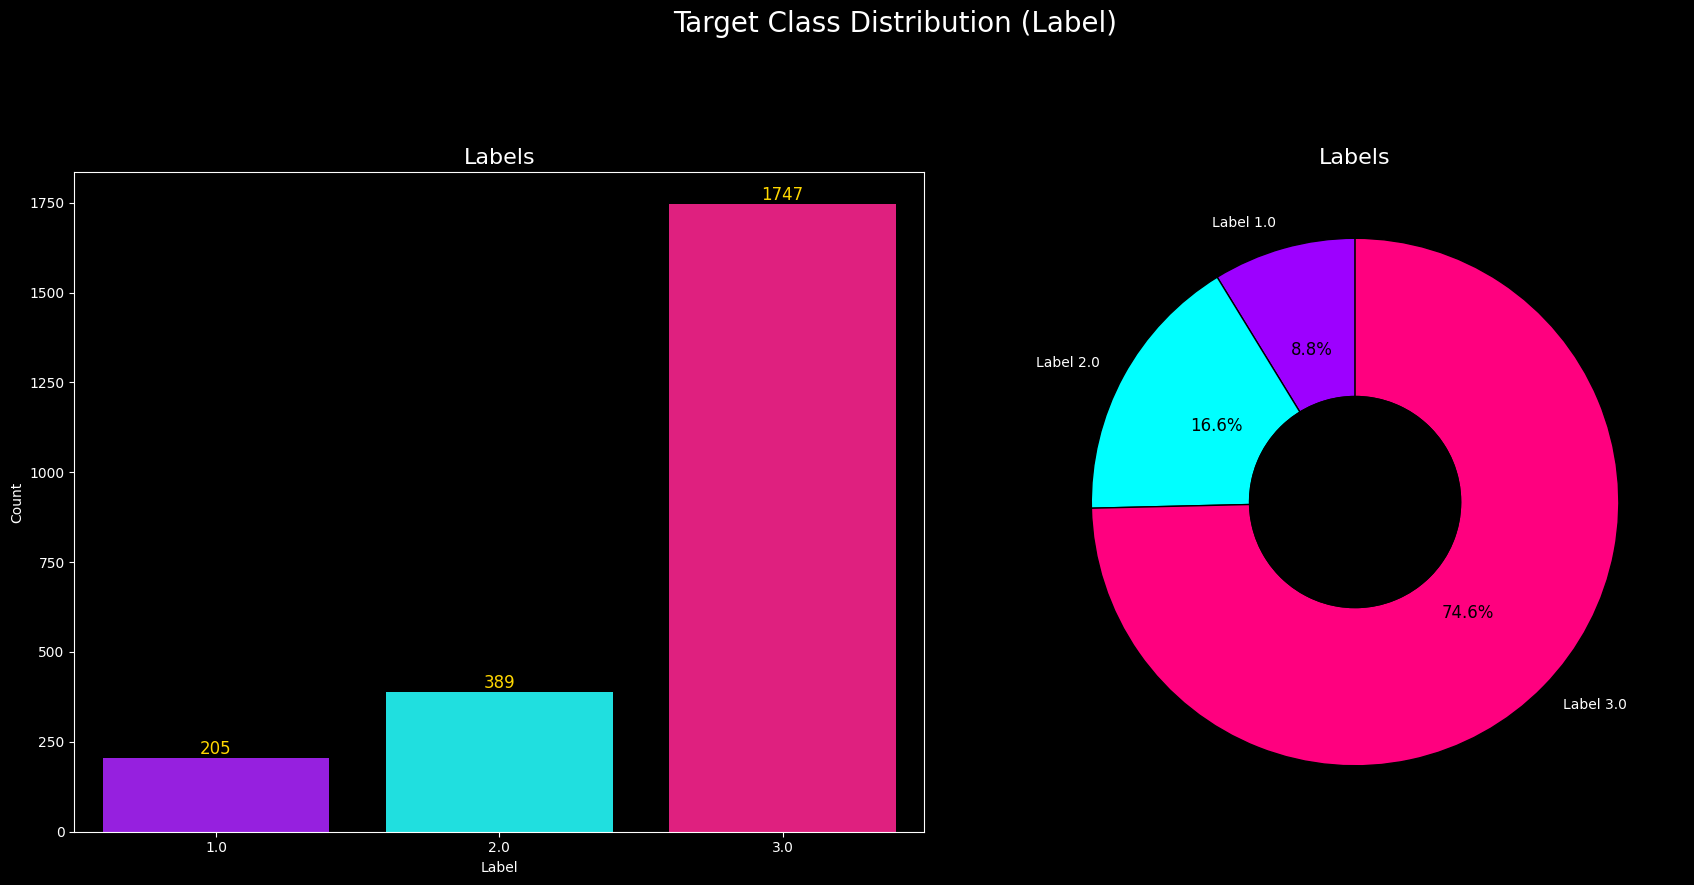

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Target Class Distribution (Label)', fontsize=20, color='white', y=1.1)

sns.countplot(
    x='engagement_level',
    data=df_proc,
    ax=axes[0],
    palette=DARK_PALETTE
)
axes[0].set_title('Labels', fontsize=16, color='white')
axes[0].set_xlabel('Label', color='white')
axes[0].set_ylabel('Count', color='white')
axes[0].tick_params(colors='white')


# Add counts on top of bars
for p in axes[0].patches:
    count = int(p.get_height())
    axes[0].annotate(
        str(count),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        color='gold',
        fontsize=12
    )

label_counts = df_proc['engagement_level'].value_counts().sort_index()
colors = sns.color_palette(DARK_PALETTE, n_colors=len(label_counts))

_, texts, autotexts = axes[1].pie(
    label_counts,
    labels=[f'Label {l}' for l in label_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.6, edgecolor='k')
)

# Style the pie text for dark background
for text in texts:
    text.set_color('white')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)

# Center circle to make it a donut
centre_circle = plt.Circle((0,0), 0.4, fc='k', edgecolor='k')
axes[1].add_artist(centre_circle)
axes[1].set_title('Labels', fontsize=16, color='white')

plt.tight_layout()
plt.show()

In [43]:
KEY_FEATURES = ['blink_state', 'face_det_ms','blink_rate_10s_bps', 
                'pitch_deg','yaw_deg']

numeric_features = [f for f in KEY_FEATURES if df_proc[f].dtype != 'object']
categorical_features = [f for f in KEY_FEATURES if df_proc[f].dtype == 'object']


with mlflow.start_run(run_name="feature_distributions", nested=True):

    fig, axes = plt.subplots(1, len(KEY_FEATURES), figsize=(5 * len(KEY_FEATURES), 6))
    fig.suptitle('Distribution of Key Features by Target Label', fontsize=18)

    # --- Numeric KDE plots ---
    for idx, col in enumerate(numeric_features):
        sns.kdeplot(
            data=df_proc,
            x=col,
            hue='engagement_level',
            fill=True,
            ax=axes[idx],
            linewidth=2.5
        )
        axes[idx].set_title(col, fontsize=14)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.5)


    # --- Categorical Countplots ---
    offset = len(numeric_features)
    for j, col in enumerate(categorical_features):
        sns.countplot(
            data=df_proc,
            x=col,
            hue='engagement_level',
            ax=axes[offset + j]
        )
        axes[offset + j].set_title(col, fontsize=14)
        axes[offset + j].tick_params(axis='x', rotation=45)
        axes[offset + j].grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])


    fig_path = os.path.join(ARTIFACTS_DIR, "feature_distributions.png")
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.close()

    mlflow.log_artifact(fig_path)
    
    mlflow.log_param("num_numeric_features", len(numeric_features))
    mlflow.log_param("num_categorical_features", len(categorical_features))
    mlflow.log_param("visualization_type", "kde + countplot mixed")

print("✔ Visualization saved & logged to MLflow successfully")

✔ Visualization saved & logged to MLflow successfully


## Models

In [44]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=150, max_depth=15, min_samples_split=4, min_samples_leaf=2, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        penalty='l2', C=1.0, solver='lbfgs', max_iter=500, random_state=42
    ),
    "SVM": SVC(kernel="rbf", C=5.0, gamma='scale', probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance')
}

## Train

In [45]:
def train_and_log_model(name, model, X_train, X_test, y_train, y_test, features, label_encoder):

    with mlflow.start_run(run_name=name , nested=True):

        try:
            mlflow.log_params(model.get_params())
        except Exception:
            mlflow.log_param("model_class", str(type(model)))


        model.fit(X_train, y_train)
        preds = model.predict(X_test)


        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, average="macro", zero_division=0)
        rec = recall_score(y_test, preds, average="macro", zero_division=0)
        f1 = f1_score(y_test, preds, average="macro", zero_division=0)
        mlflow.log_metric("accuracy", float(acc))
        mlflow.log_metric("precision_macro", float(prec))
        mlflow.log_metric("recall_macro", float(rec))
        mlflow.log_metric("f1_macro", float(f1))
        
        # classification report
        cr = classification_report(y_test, preds, output_dict=True)
        report_path = os.path.join(ARTIFACTS_DIR, f"classification_report_{name}.json")
        with open(report_path, "w") as fh:
            json.dump(cr, fh, indent=2)
        mlflow.log_artifact(report_path)

        # confusion matrix
        labels = sorted(list(np.unique(y_test)))
        log_confusion_matrix(y_test, preds, labels, f"confusion_matrix_{name}")


        try:
            if hasattr(model, "feature_importances_"):
                fi = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
                fip = os.path.join(ARTIFACTS_DIR, f"feature_importance_{name}.csv")
                fi.to_csv(fip)
                mlflow.log_artifact(fip)
                fig = plt.figure(figsize=(10,6))
                sns.barplot(x=fi.values, y=fi.index)
                plt.title(f"Feature Importance - {name}")
                plt.tight_layout()
                log_matplotlib_fig(fig, f"feature_importance_{name}")
                plt.close(fig)
        except Exception:
            pass

        # model artifact
        mlflow.sklearn.log_model(model, name=f"model_{name}")
        print(f"[{name}] acc={acc:.4f}, f1_macro={f1:.4f}")
        return {"name": name, "accuracy": acc, "f1_macro": f1}




results = []
for nm, mdl in models.items():
    res = train_and_log_model(nm, mdl, X_train, X_test, y_train, y_test, FEATURES, label_encoder)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
results_df

2025/11/17 07:31:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpyx1uad1_/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/11/17 07:31:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[RandomForest] acc=0.9296, f1_macro=0.8220


2025/11/17 07:31:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpe4ok5u38/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/11/17 07:31:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LogisticRegression] acc=0.8635, f1_macro=0.6404


2025/11/17 07:31:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5_rhvl6y/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/11/17 07:31:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[SVM] acc=0.9147, f1_macro=0.7964


2025/11/17 07:31:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpulxekhbm/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/11/17 07:31:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[DecisionTree] acc=0.9211, f1_macro=0.8055


2025/11/17 07:31:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5x5vyvlj/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/11/17 07:31:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[KNN] acc=0.8934, f1_macro=0.7570


,name,accuracy,f1_macro
0,RandomForest,0.929638,0.822008
1,DecisionTree,0.921109,0.805510
2,SVM,0.914712,0.796420
3,KNN,0.893390,0.756993
4,LogisticRegression,0.863539,0.640363


In [46]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x="name", y="f1_macro", data=results_df)
plt.title("Model comparison — F1 (macro)")
plt.ylim(0,1)
plt.tight_layout()
log_matplotlib_fig(fig, "models_f1_comparison")
plt.close(fig)
results_df

with mlflow.start_run(run_name="model_comparison", nested=True):
    results_path = os.path.join(ARTIFACTS_DIR, "model_comparison_results.csv")
    results_df.to_csv(results_path, index=False)
    mlflow.log_artifact(results_path)
    print("Model comparison results logged:", results_path)

Model comparison results logged: artifacts/model_comparison_results.csv


## Save Model & Summary

In [47]:
best_row = results_df.iloc[0]
best_model_name = best_row['name']
print("Selected best model:", best_model_name)

best_model = models[best_model_name]
best_model.fit(X_train, y_train)  # re-fit to ensure trained
local_model_path = os.path.join(PROCESSED_DIR, f"best_model_{best_model_name}.joblib")
joblib.dump(best_model, local_model_path)

with mlflow.start_run(run_name="final_summary", nested=True):
    mlflow.log_param("best_model", best_model_name)
    res_csv = os.path.join(ARTIFACTS_DIR, "model_results_summary.csv")
    results_df.to_csv(res_csv, index=False)
    mlflow.log_artifact(res_csv)
    mlflow.log_artifact(local_model_path)

print("Saved & logged best model:", local_model_path)

Selected best model: RandomForest
Saved & logged best model: processed/best_model_RandomForest.joblib


## Predict

In [48]:
def predict_single_row(model, scaler, row_dict, features=FEATURES, label_encoder=label_encoder):
    row = pd.DataFrame([row_dict])
    for f in features:
        if f not in row.columns:
            row[f] = df_proc[f].median()
    X_row = row[features].astype(float)
    X_scaled = scaler.transform(X_row)
    pred_enc = model.predict(X_scaled)[0]
    try:
        label = label_encoder.inverse_transform([pred_enc])[0]
    except Exception:
        label = str(pred_enc)
    return label